# Part 1 : Sampling and filtering

In this part of the lab work, we are going to look at the frequency content of images, and certain filtering operations which which we can carry out.

__Note__ : in this part of the TP, we will avoid using plt.imshow(). Indeed, if you use imshow to display an image, it will change the resolution of this image. Since we are going to be looking at aliasing effects (which is induced precisely by changing resolution), it is better to write the output to an image file and view it in a separate program.

First, let us load the necessary packages

__N.B: I used imshow and I downoalded the images as well to see them with their normal resolution__

In [422]:
!pip install opencv-python

You should consider upgrading via the 'c:\users\asus\anaconda3\envs\my-env\python.exe -m pip install --upgrade pip' command.


In [423]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
import cv2

is_colab= False

The last package will help us to carry out the convolution operation. Let's define two functions to read and write and image :

In [424]:
def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))

In [425]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

(600, 600)

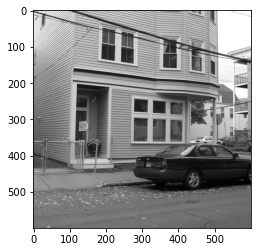

In [426]:
plt.imshow(img_gray, cmap='gray')

## Frequency content

Firstly, we are going to inspect the frequency content of the image. Write a function to display the magnitude of the spectrum of the image. For this, you can use the following functions

- ``np.fft.fft2``
- ``np.fft.fftshift``

The first calculates the 2D Fast Fourier Transform of the image. The second centres the spectrum, such that the 0 frequency is centred in the image. Otherwise the 0 point is set at the top left, which is not very conveniant for visualisation.

A final note. It is often the case that the 0 frequency is of much larger amplitude than the other frequencies. Therefore, we often visualise log(1+spectrum_magnitude) rather than spectrum_magnitude itself.

Write this function ``display_spectrum`` now.

In [427]:
def display_spectrum(img):
    #INSERT CODE HERE
    magnitude_spectrum = np.fft.fftshift(np.fft.fft2(img))
    magnitude_spectrum= np.abs(np.log(1 + magnitude_spectrum))
    return magnitude_spectrum

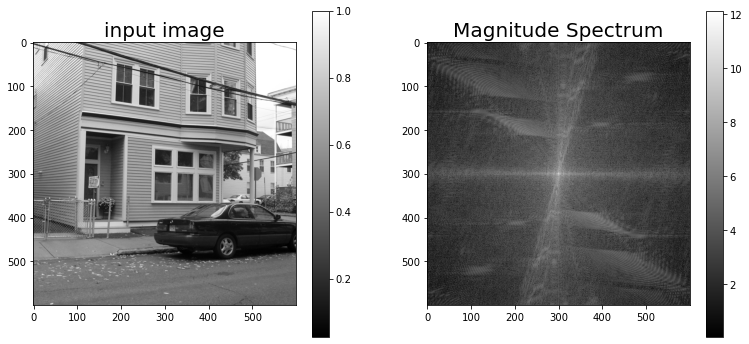

In [428]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.title('input image',  fontsize=20) 
plt.colorbar()

plt.subplot(132)
plt.imshow(display_spectrum(img_gray).astype(float)  , cmap='gray')
plt.title('Magnitude Spectrum',  fontsize=20) 
plt.colorbar()


__Question__ 1.1 : What do you observe in the frequency domain ? What is your interpretation of this image ?

__Answer__ :The output frequency domain image tells us how much each frequency component is included in the original image. Pixels near the center represent lower frequency components, and outer side pixels represent higher frequency component. 

The figure shows that the low frequencies are the most dominanting, and the brightest point on the frequency domain is located in the center of the plot. Moreover, we can see a high variance of the gray space levels like stairs along the diagonal which is maybe caused by the house's tiles. 

## Subsampling and aliasing

We are now going to carry out a ''direct'' subsampling (also known as a ''nearest neighbours'' subsampling of a factor $\delta$, that is to say we simply take one out of every two pixels. Fill in the following function to do this :

First Method

In [429]:
def nn_subsampling(img_in,delta):
    #INSERT CODE HERE
    return(img_in[::delta,::delta])

Second Method: using cv2

In [430]:
def nn_subsampling(img_in,delta):
    return cv2.resize(img_in, None,fx=1/delta, fy=1/delta,interpolation=cv2.INTER_NEAREST)

We write the subsampled image, with subsampling step $\delta = 2$

In [431]:
delta = 2
image_small = nn_subsampling(img_gray,delta)
print(image_small.shape)
write_image(image_small, file_name+'_subsampled.png')

(300, 300)


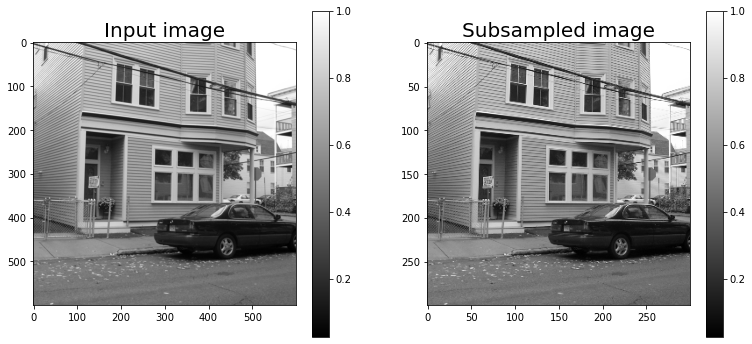

In [432]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.title('Input image',  fontsize=20) 
plt.colorbar()

plt.subplot(132)
plt.imshow(image_small, cmap='gray')
plt.title('Subsampled image',  fontsize=20) 
plt.colorbar()

__Question__ 1.2 What do you notice about the image ? Where is the aliasing taking place ? Why is it taking place in these specific regions ?

__Answer__ :

The image is of low resolution since it is subsampled, that means its dimensions are half the original dimensions, also we notice that the house's tiles representation is different than anything present in the original image. We can say that the image is not well-sampled. 

We note that the aliasing effect takes place on the line shapes, particularly on the house's tiles. 

The aliasing is taking place in these specific regions exactly because they correspond to high frequency regions as we noticed in the magnitude spectrum representation of the image. 

This effect is engendred in these regions because of the subsampling method which creates also some discontinuity, and this is because that the sampling rate is not high enough to capture all the frequencies. That means that the shannon's sampling theorem is not taking into consideration here and that the sampling rate is not higher than twice the highest frequency. 

We have seen two different methods of filtering an image before subsampling to remove high frequencies :

- Ideal low-pass filter
- Gaussian filter

We recall that the convolution operation, which defines a filter, can be carried out either in the time domain or the frequency domain.

Write a function which filters an input image via the frequency domain, with the input filter $f_hat$ defined in the frequency domain. The output ``img_out`` should be in the spatial domain. You can use the ``np.fft.ifft2`` function to carry out the inverse Fourier transform. Make sure to take the __real__ part of the output image (``np.real``).

In [433]:
def filter_image(img,f_hat):
    
    #INSERT CODE HERE
    fft = np.fft.fft2(img)
    fft_shift = np.fft.fftshift(fft)
    fft_shift_output = fft_shift * f_hat
    freq = np.fft.ifftshift(fft_shift_output)
    img_out = np.real(np.fft.ifft2(freq))
    return(img_out)

Now, create a function ``ideal_low_pass_filter`` which returns an ideal low-pass filter $\hat{h}$ in the frequency domain. Note : by definition the 0 frequency is at the top left point of the image. To convert it to this format, you can use the ``np.fft.ifftshift`` function (which inverses the fftshift). In the ''centred'' representation of the frequency, for an image of even size $n=2a$, the 0 frequency position is located at position $a$ (where 0 is the first position).

Hint : the distance transform ``scipy.ndimage.morphology.distance_transform_edt`` can be useful here.

In [434]:
from scipy.ndimage.morphology import distance_transform_edt
def ideal_low_pass_filter(img_shape,nu_0):
    #Creating the idea_low_pass_filter
    f_hat= np.ones(img_shape)
    #Setting the center to 0
    f_hat[img_shape[0] // 2, img_shape[1] // 2] = 0
    #Calculating distance to center
    f_hat=distance_transform_edt(f_hat)
    f_hat /= f_hat.max()

    for m in range(img_shape[0]):
        for n in range(img_shape[1]):
            if f_hat[m,n] <nu_0 :
                f_hat[m,n]=1
            else :
                f_hat[m,n]=0
  
    return(f_hat)


__Question 1.3__ Given that in an image with sampling rate 1 (the pixel size) the frequencies in the original image of size $n \times n$ go from $-\frac{1}{2}$ to $\frac{1}{2}$, at positions $-\frac{n}{2}$ to $\frac{n}{2}$ in a ''centred'' representation of the spectrum.  For a subsampling of $\delta=2$, where should the cutoff frequency $\nu_0$ be set for correct subsampling ?

__Answer__ : Based on the Shannon Theorem $
\nu_{m} = \frac{1}{2 \delta} = \frac{1}{4}.
$

Create f_hat, the ideal low-pass filter in the frequency domain, and display it.

(600, 600)


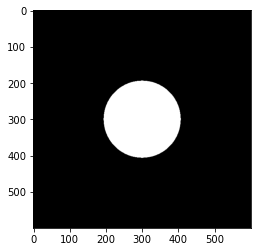

In [435]:
img_shape = img_gray.shape
print(img_shape)
#INSERT CODE HERE
nu_0 = 0.25
f_hat = ideal_low_pass_filter(img_shape,nu_0)
plt.imshow(f_hat,cmap='gray')

In [436]:
#Filetring without normalisation
img_filtered = filter_image(img_gray,f_hat)

#INSERT CODE HERE
img_filtered = nn_subsampling(img_filtered, delta)

write_image(img_filtered,file_name+'_filtered_ideal_low_pass.png')

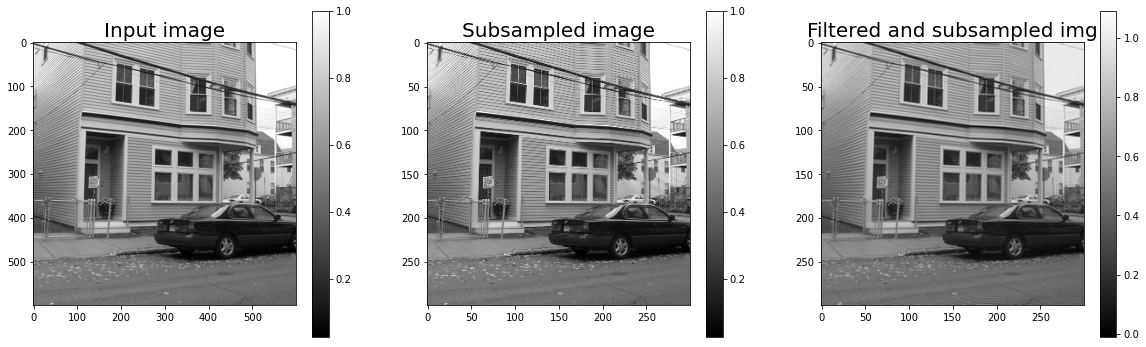

In [437]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.title('Input image',  fontsize=20) 
plt.colorbar()

#sabsampled image without filtering
plt.subplot(132)
plt.imshow(image_small, cmap='gray')
plt.title('Subsampled image',  fontsize=20) 
plt.colorbar()

#subsampled image after filtering
plt.subplot(133)
plt.imshow(img_filtered, cmap='gray')
plt.title('Filtered and subsampled img',  fontsize=20) 
plt.colorbar()

Carry out the filtering, and subsample the image again, and imwrite the result.

You should observe that the range of the image is not respected. Make sure to rescale the output image to the range $0, \dots, 1$ before writing it.

__Question 1.4__ Why do you think this happens ?

__Answer__ :  This happens because when we carry out the filtering we apply a multiplication between the filter and image in the frequnecy space and then with the reverse Fourrier tranform, some elements of the matrix representing the image may be out of range hence the need to rescale.

The input image in the frequency domain has a DC component which represents the mean of the pixel values, same applies to the ideal low pass filter who has a differnt DC component, by multiplying the two we got a new value of the DC component that needs to be rescaled to the range 0,...,1.

In [438]:
img_filtered = filter_image(img_gray,f_hat)

#INSERT CODE HERE
img_filtered = (img_filtered - np.min(img_filtered)) / (np.max(img_filtered) - np.min(img_filtered))  # normalize image
#INSERT CODE HERE
img_filtered = nn_subsampling(img_filtered, delta)

write_image(img_filtered,file_name+'_filtered_ideal_low_pass.png')

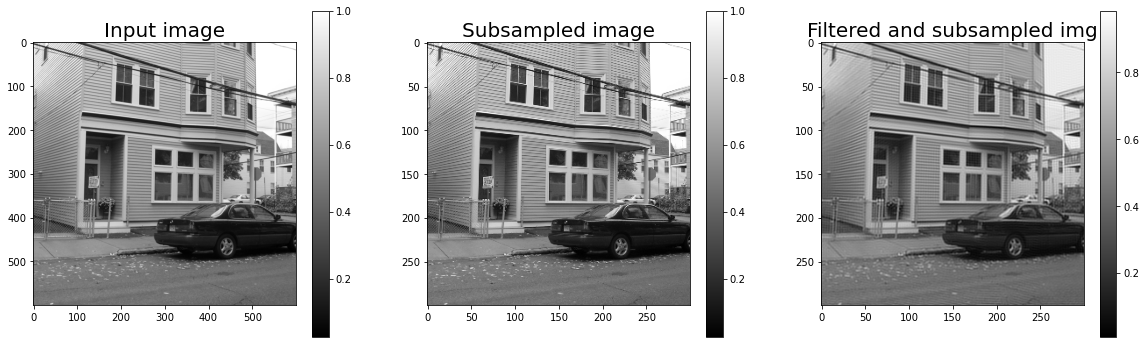

In [439]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.title('Input image',  fontsize=20) 
plt.colorbar()

#subsampled image without filtering
plt.subplot(132)
plt.imshow(image_small, cmap='gray')
plt.title('Subsampled image',  fontsize=20) 
plt.colorbar()

#subsampled image after filetring
plt.subplot(133)
plt.imshow(img_filtered, cmap='gray')
plt.title('Filtered and subsampled img',  fontsize=20) 
plt.colorbar()

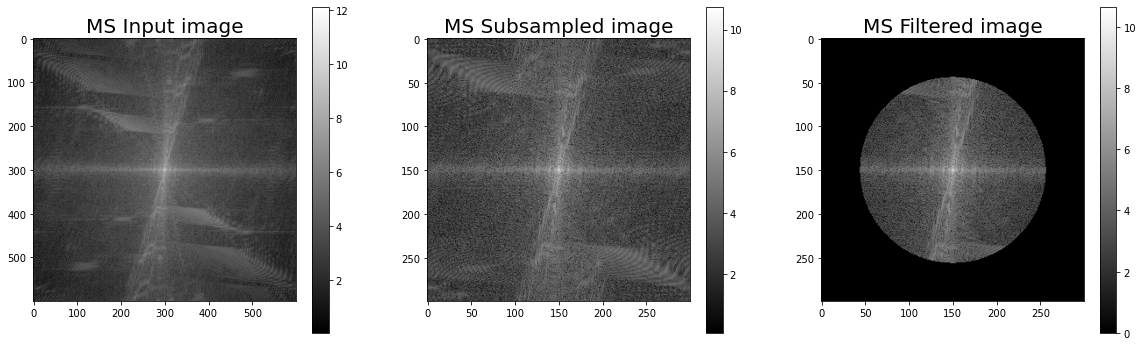

In [440]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(display_spectrum(img_gray).astype(float), cmap='gray')
plt.title('MS Input image',  fontsize=20) 
plt.colorbar()

plt.subplot(132)
plt.imshow(display_spectrum(image_small).astype(float), cmap='gray')
plt.title('MS Subsampled image',  fontsize=20) 
plt.colorbar()


plt.subplot(133)
plt.imshow(display_spectrum(img_filtered).astype(float), cmap='gray')
plt.title('MS Filtered image',  fontsize=20) 
plt.colorbar()

__Question 1.5__ Is the aliasing reduced ? What effect do you notice in the output ? What is this called ?

__Answer__ : The ideal low pass filter reduced the aliasing, but unfortunately this decreases the brightness and makes the image looks blurrier. 

We notice that there is rippling artifacts near the deges It is called the ringing artifacts effect.

The low-pass filter not only surpress high frequencies but also some low frequency components, which are responsible for general image structures and are supposed not to be lost.

Completely removing aliasing would require an ideal low-pass
filter (a gate function). This is not possible in reality with a finite
signal; the support of the inverse FT of the gate function (a sinc) is
infinite.

Now, we are going to carry out the filtering with a Gaussian filter. Create a function ``gaussian_filter`` which returns a 2D Gaussian filter, defined as :

$g_\sigma(x,y) = \frac{1}{2 \pi \sigma^2} \exp{ \left( - \frac{x^2+y^x}{2\sigma^2} \right)}$

To create a grid of pixel positions, you can use the ``np.meshgrid`` function.

You must again make sure to carry out an ``ifftshift`` to make sure the filter is in the correct format. Be careful to put the middle of the Gaussian at the centre position ($a$).

In [441]:
def gaussian_filter(img_shape,sigma):
    #INSERT CODE HERE
    w,h = img_shape[0],img_shape[1]
    interval_w=np.linspace(-(w - 1) / 2., (w - 1) / 2., w)
    interval_h=np.linspace(-(h - 1) / 2., (h - 1) / 2., h)
    x,y = interval_w, interval_h
    Y, X = np.meshgrid(y, x)
    rt = np.exp(-0.5 * (np.square(Y) + np.square(X)) / np.square(sigma * h))
    g=1/(2*np.pi*np.square(sigma * h))*rt
#     g = rt / np.sum(rt)
    return g

Now, create a Gaussian filter in the frequency domain to attenuate the frequencies higher than the previous cutoff frequency you used above, $\nu_0$. To do this, we recall that 95.45 percent of the energy of a Gaussian function is contained within $\pm 2\sigma$. Fix $\sigma$ accordingly. Display the filter.

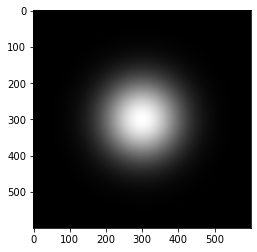

In [442]:
#INSERT CODE HERE
img_shape = img_gray.shape
sigma = nu_0/2
g_hat = gaussian_filter(img_gray.shape,sigma=sigma)
plt.imshow(g_hat,cmap='gray')

Now, carry out the filtering with the Gaussian filter in the frequency domain. Remember to rescale the output image.

In [443]:
#INSERT CODE HERE
img_filtered = filter_image(img_gray,g_hat)
img_filtered = (img_filtered - img_filtered.min()) / (img_filtered.max() - img_filtered.min())
img_filtered = nn_subsampling(img_filtered,delta)
write_image(img_filtered,file_name+'_filtered_gaussian.png')

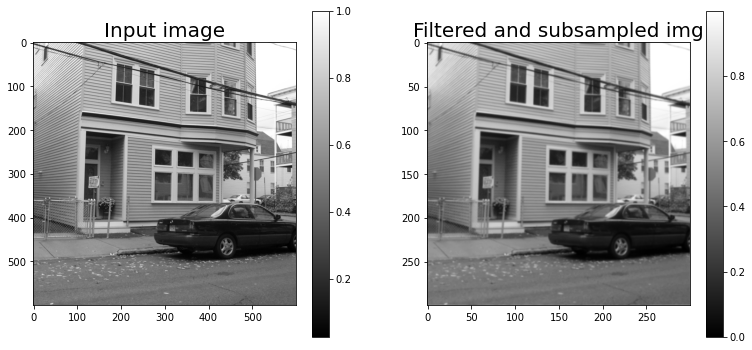

In [444]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.title('Input image',  fontsize=20) 
plt.colorbar()

#subsampled image with filter
plt.subplot(132)
plt.imshow(img_filtered, cmap='gray')
plt.title('Filtered and subsampled img',  fontsize=20) 
plt.colorbar()

__Question 1.6__ Do you still observe the problem observed in the case of the ideal low-pass filter ? Why ?

__Answer__ : By using the Gaussian filter we don't see the problem observed in the case of the ideal low-pass filter anymore. 

This can be explained by the soft thresholding used here, also the FT of a Gaussian is also a Gaussian function and the gaussian filter is not oscillatory and positive.

__Question 1.7__ We have had to rescale the output image again. This time, why was this the case ? Hint : think about a Gaussian filter in the spatial domain with a very large $\sigma$.

__Answer__ : A Gaussian filter in the spatial domain with a very large $\sigma$ will result in a gaussian filter spectrum with a very small variance because the variance is inverted in the Fourier domain. 

A Gaussian filter with very large $\sigma$ means the cuoff frequency is very low hence when we filter the image most of the information will come from the center of the image where the magnitude of the spectrum is biggest hence we obtain large value and need to rescale.

## Standard filters

In this section, we are going to look at some common filters, and see their effects on images. From this point on in the TP, we are going to be working in the spatial domain, and are no longer concentrated on aliasing. Therefore, we can use the plt.imshow function (you may notice some aliasing, but we ignore it here). We define a display function now.

In [445]:
def display_image(img_in):
    plt.imshow(img_in,cmap='gray')

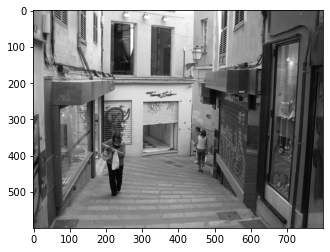

In [446]:
file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)

Now, write a function ``filter_image_spatial`` which carries out the 2D convolution between two images in the spatial domain. For this, you can use the ``convolve2d`` from the scipy.signal package. In this convolution, you should use the following parameters :

- mode='same'. This means that the output size of the image will be the same as the input
- boundary='symm'. For values outside the image domain, we take the symmetrical values of the image

Strictly speaking, if we take the Fourier transform of an image, we are using periodic boudary conditions. However, at this point we no longer need the frequency representation of the image, so we can define the conditions as we wish.

In [447]:
from scipy import signal
def filter_image_spatial(img,f):
    #INSERT CODE HERE
    img_out = signal.convolve2d(img, f, mode='same', boundary='symm')
    return(img_out)

Now, define the filters grad_y and grad_x which give the derivatives of the image in the $y$ and $x$ directions, resepctively (see lesson slides). Note : you must define these filters in the spatial domain, and make sure that they are matrices (otherwise the dimensions will not match with those of the image);

In [448]:
#INSERT CODE HERE
grad_x = np.array([-1,1]).reshape(1,-1)
grad_y = np.array([-1,1]).reshape(-1,1)

In [449]:
grad_x

array([[-1,  1]])

In [450]:
grad_y

array([[-1],
       [ 1]])

Filter the input image and display the results of these two filterings

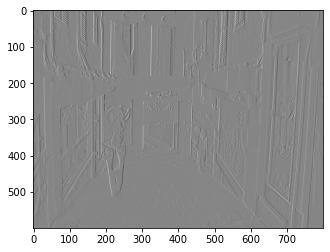

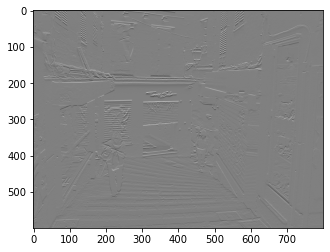

In [451]:
#INSERT CODE HERE
img_grad_x = filter_image_spatial(img_gray,grad_x)
img_grad_y = filter_image_spatial(img_gray,grad_y)

display_image(img_grad_x)
plt.figure()
display_image(img_grad_y)

Suppose we wish to create a sketch of our image, with just the outlines of object. Propose a (simple) method to create a binary image where the edges are shown. Implement this in a function called ``sketch_image``, and apply it to the input image. Display it (you can write it as well to view it better).

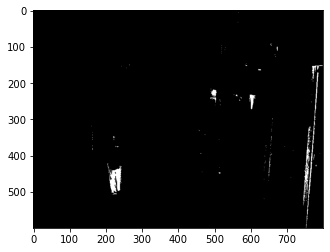

In [452]:
def sketch_image(img_in,tau):
    #INSERT CODE HERE
    g_hat = gaussian_filter(img_in.shape, 0.5)
    img_blur = filter_image(img_in,g_hat)
    img_blur = (img_blur - np.min(img_blur)) / (np.max(img_blur) - np.min(img_blur))
    img_out = img_blur * 1 / (1 - img_in + 1e-10)
    img_out[img_out > tau] = 1.
    img_out = 1-img_out.astype('uint8')
    return img_out

tau = 0.05
img_sketch = sketch_image(img_gray,tau)
display_image(img_sketch)
write_image(img_sketch, file_name+'_sketch.png')

Depending on the threshold used in your algorithm, the sketch may have a certain thickness. Ideally, we would like to have a sketch of one-pixel thickness. This is something we would like to avoid in the sketch. Propose a solution (using the information in the lesson) to this using morphological operators, and implement it. You can find the necessary function in the following package (do not reimplement this operation, there is alread a function which exists) :

- skimage.morphology

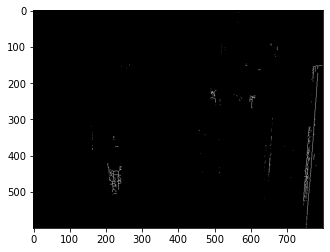

In [453]:
#INSERT CODE HERE

from skimage.morphology import skeletonize

img_sketch_skeleton = skeletonize(img_sketch)
display_image(img_sketch_skeleton)
write_image(img_sketch_skeleton, file_name+'_sketch_skeleteon.png')